### Epochs = 20, Learning rate = 0.001, batch size = 16, image size = 256 x 256

#### Conclusions: larger image size produces worse results

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class PetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with the dataset.
            split (string): 'train', 'val', or 'test' split.
            transform (callable, optional): Transform to be applied on the input image.
            target_transform (callable, optional): Transform to be applied on the mask.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        
        # Set paths for images and masks
        self.image_dir = os.path.join(root_dir, split, 'color')
        self.mask_dir = os.path.join(root_dir, split, 'label')
        
        # Get all image file names
        self.image_files = sorted([f for f in os.listdir(self.image_dir) 
                                  if os.path.isfile(os.path.join(self.image_dir, f))])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Get corresponding mask file
        mask_name = img_name.replace('.jpg', '.png')  # Adjust if your mask extension differs
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        
        # Load and process mask
        mask = Image.open(mask_path).convert('RGB')

        mask_np = np.array(mask)
        
        # Convert RGB mask to class indices
        # Create a segmentation mask: 0=background, 1=cat, 2=dog, 255=ignore
        seg_mask = np.zeros(mask_np.shape[:2], dtype=np.uint8)
        
        # Background (black)
        black_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[black_mask] = 0

        # Cat (red)
        red_mask = (mask_np[:,:,0] == 128) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[red_mask] = 1

        # Dog (green)
        green_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 128) & (mask_np[:,:,2] == 0)
        seg_mask[green_mask] = 2

        # White border (ignore)
        white_mask = (mask_np[:,:,0] == 255) & (mask_np[:,:,1] == 255) & (mask_np[:,:,2] == 255)
        seg_mask[white_mask] = 255  # Use 255 as ignore index

        # Create a PIL Image from the segmentation mask
        seg_mask_pil = Image.fromarray(seg_mask)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            seg_mask_pil = self.target_transform(seg_mask_pil)
            # Convert back to tensor
            seg_mask = torch.from_numpy(np.array(seg_mask_pil)).long()
        else:
            seg_mask = torch.from_numpy(seg_mask).long()
        
        return image, seg_mask

In [3]:
img_size = 256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST),
])

In [4]:
# Create datasets
data_root = '../Dataset/'  # Adjust path as needed
trainval_dataset = PetDataset(data_root, 'TrainVal', transform, target_transform)
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])
test_dataset = PetDataset(data_root, 'Test', transform, target_transform)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Training set size: 2944
Validation set size: 736
Test set size: 3710


In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features_start=32):
        super(UNet, self).__init__()
        
        # Starting with 256x256 input
        # After 5 max pools of stride 2: 256 -> 128 -> 64 -> 32 -> 16 -> 8
        
        # Encoder (Downsampling)
        self.encoder1 = DoubleConv(in_channels, features_start)  # 256 -> 256
        self.pool1 = nn.MaxPool2d(2)  # 256 -> 128
        self.encoder2 = DoubleConv(features_start, features_start*2)  # 128 -> 128
        self.pool2 = nn.MaxPool2d(2)  # 128 -> 64
        self.encoder3 = DoubleConv(features_start*2, features_start*4)  # 64 -> 64
        self.pool3 = nn.MaxPool2d(2)  # 64 -> 32
        self.encoder4 = DoubleConv(features_start*4, features_start*8)  # 32 -> 32
        self.pool4 = nn.MaxPool2d(2)  # 32 -> 16
        self.encoder5 = DoubleConv(features_start*8, features_start*16)  # 16 -> 16
        self.pool5 = nn.MaxPool2d(2)  # 16 -> 8
        
        # Bottom
        self.bottom = DoubleConv(features_start*16, features_start*32)  # 8 -> 8
        
        # Decoder (Upsampling)
        self.upconv5 = nn.ConvTranspose2d(features_start*32, features_start*16, kernel_size=2, stride=2)  # 8 -> 16
        self.decoder5 = DoubleConv(features_start*32, features_start*16)  # 16 -> 16
        self.upconv4 = nn.ConvTranspose2d(features_start*16, features_start*8, kernel_size=2, stride=2)  # 16 -> 32
        self.decoder4 = DoubleConv(features_start*16, features_start*8)  # 32 -> 32
        self.upconv3 = nn.ConvTranspose2d(features_start*8, features_start*4, kernel_size=2, stride=2)  # 32 -> 64
        self.decoder3 = DoubleConv(features_start*8, features_start*4)  # 64 -> 64
        self.upconv2 = nn.ConvTranspose2d(features_start*4, features_start*2, kernel_size=2, stride=2)  # 64 -> 128
        self.decoder2 = DoubleConv(features_start*4, features_start*2)  # 128 -> 128
        self.upconv1 = nn.ConvTranspose2d(features_start*2, features_start, kernel_size=2, stride=2)  # 128 -> 256
        self.decoder1 = DoubleConv(features_start*2, features_start)  # 256 -> 256
        
        # Final Convolution
        self.final_conv = nn.Conv2d(features_start, out_channels, kernel_size=1)  # 256 -> 256

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 256
        enc2 = self.encoder2(self.pool1(enc1))  # 128
        enc3 = self.encoder3(self.pool2(enc2))  # 64
        enc4 = self.encoder4(self.pool3(enc3))  # 32
        enc5 = self.encoder5(self.pool4(enc4))  # 16
        
        # Bottom
        bottom = self.bottom(self.pool5(enc5))  # 8
        
        # Decoder with skip connections
        dec5 = self.upconv5(bottom)  # 16
        dec5 = torch.cat([dec5, enc5], dim=1)
        dec5 = self.decoder5(dec5)
        
        dec4 = self.upconv4(dec5)  # 32
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)  # 64
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)  # 128
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)  # 256
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

In [6]:
def train_unet(model, train_loader, val_loader, num_epochs=30, device=device):
    """
    Train the U-Net model.
    
    Args:
        model: U-Net model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of epochs to train
        device: Device to train on
        
    Returns:
        Trained model
    """
    # Define loss function for segmentation (with ignore_index for white pixels)
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Track best model
    best_val_loss = float('inf')
    best_model = None
    
    # Training history
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss (outputs shape: [B, C, H, W], masks shape: [B, H, W])
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track loss
            running_loss += loss.item() * images.size(0)
        
        # Calculate average training loss
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                # Move data to device
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Track loss
                val_running_loss += loss.item() * images.size(0)
        
        # Calculate average validation loss
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            print(f"New best model saved with validation loss: {val_loss:.4f}")
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model

c:\Users\dcb_r\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training U-Net...


Epoch 1/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.69it/s]


Epoch [1/20], Train Loss: 0.6714, Val Loss: 0.6209
New best model saved with validation loss: 0.6209


Epoch 2/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.78it/s]


Epoch [2/20], Train Loss: 0.5935, Val Loss: 0.5749
New best model saved with validation loss: 0.5749


Epoch 3/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.90it/s]


Epoch [3/20], Train Loss: 0.5518, Val Loss: 0.5388
New best model saved with validation loss: 0.5388


Epoch 4/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.77it/s]


Epoch [4/20], Train Loss: 0.5133, Val Loss: 0.6999


Epoch 5/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.80it/s]


Epoch [5/20], Train Loss: 0.4869, Val Loss: 0.5648


Epoch 6/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.74it/s]


Epoch [6/20], Train Loss: 0.4607, Val Loss: 0.4463
New best model saved with validation loss: 0.4463


Epoch 7/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.98it/s]


Epoch [7/20], Train Loss: 0.4377, Val Loss: 0.4736


Epoch 8/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  7.07it/s]


Epoch [8/20], Train Loss: 0.4127, Val Loss: 0.4335
New best model saved with validation loss: 0.4335


Epoch 9/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  7.02it/s]


Epoch [9/20], Train Loss: 0.4008, Val Loss: 0.4121
New best model saved with validation loss: 0.4121


Epoch 10/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  7.04it/s]


Epoch [10/20], Train Loss: 0.3824, Val Loss: 0.3993
New best model saved with validation loss: 0.3993


Epoch 11/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.69it/s]


Epoch [11/20], Train Loss: 0.3682, Val Loss: 0.4771


Epoch 12/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.66it/s]


Epoch [12/20], Train Loss: 0.3492, Val Loss: 0.4070


Epoch 13/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.68it/s]


Epoch [13/20], Train Loss: 0.3374, Val Loss: 0.3630
New best model saved with validation loss: 0.3630


Epoch 14/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.77it/s]


Epoch [14/20], Train Loss: 0.3145, Val Loss: 0.3695


Epoch 15/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.80it/s]


Epoch [15/20], Train Loss: 0.3009, Val Loss: 0.3675


Epoch 16/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.76it/s]


Epoch [16/20], Train Loss: 0.2792, Val Loss: 0.4574


Epoch 17/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.84it/s]


Epoch [17/20], Train Loss: 0.2666, Val Loss: 0.6847


Epoch 18/20 (Val): 100%|██████████| 46/46 [00:06<00:00,  6.75it/s]


Epoch [18/20], Train Loss: 0.2411, Val Loss: 0.3345
New best model saved with validation loss: 0.3345


Epoch 19/20 (Val): 100%|██████████| 46/46 [00:07<00:00,  6.50it/s]


Epoch [19/20], Train Loss: 0.2214, Val Loss: 0.3043
New best model saved with validation loss: 0.3043


Epoch 20/20 (Val): 100%|██████████| 46/46 [00:07<00:00,  6.48it/s]


Epoch [20/20], Train Loss: 0.2053, Val Loss: 0.3589


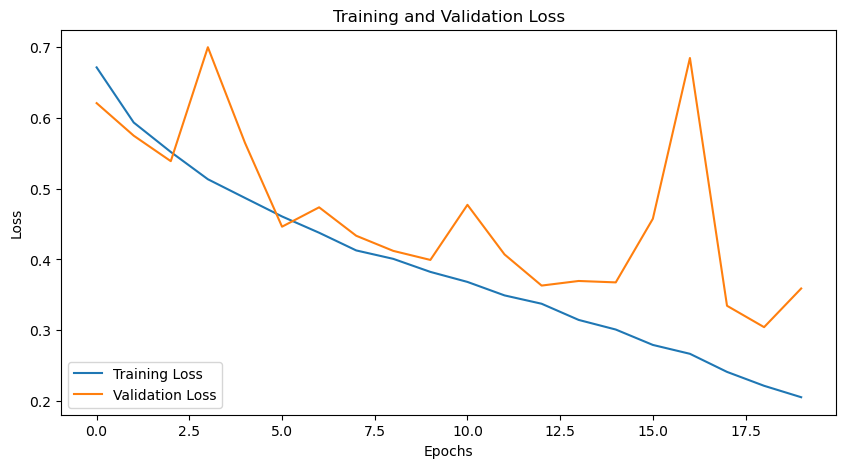

Model saved to unet_pet_segmentation.pth


In [7]:
# Create U-Net model with 3 output channels (background, cat, dog)
unet = UNet(in_channels=3, out_channels=3).to(device)

# Train U-Net model
print("Training U-Net...")
num_epochs = 20  # Adjust as needed
unet = train_unet(unet, train_loader, val_loader, num_epochs=num_epochs, device=device)

# Save the trained model
torch.save(unet.state_dict(), 'unet_pet_segmentation.pth')
print("Model saved to unet_pet_segmentation.pth")

In [8]:
def evaluate_unet(model, dataloader, device):
    """
    Evaluate the U-Net model.
    
    Args:
        model: U-Net model
        dataloader: DataLoader for evaluation data
        device: Device to evaluate on
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    
    # Initialize metrics
    correct = 0
    total = 0
    
    # Initialize IoU metrics - one for each class
    num_classes = 3  # background (0), cat (1), dog (2)
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Calculate accuracy (ignoring white pixels with value 255)
            mask = (masks != 255)
            correct += (predicted[mask] == masks[mask]).sum().item()
            total += mask.sum().item()
            
            # Calculate IoU for each class
            for cls in range(num_classes):
                pred_cls = (predicted == cls) & mask
                true_cls = (masks == cls) & mask
                
                # Intersection and union
                intersection[cls] += (pred_cls & true_cls).sum().item()
                union[cls] += (pred_cls | true_cls).sum().item()
    
    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    
    # Calculate IoU for each class
    class_names = ["background", "cat", "dog"]
    class_ious = []
    
    for cls in range(num_classes):
        iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
        class_ious.append(iou)
        print(f"IoU for {class_names[cls]}: {iou:.4f}")
    
    # Calculate mean IoU
    mean_iou = sum(class_ious) / len(class_ious)
    
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    
    return {
        "pixel_accuracy": accuracy,
        "class_ious": {class_names[i]: class_ious[i] for i in range(num_classes)},
        "mean_iou": mean_iou
    }

In [10]:
# Evaluate model on validation set
print("\nEvaluating U-Net on validation set:")
val_results = evaluate_unet(unet, val_loader, device)


Evaluating U-Net on validation set:


Evaluating: 100%|██████████| 46/46 [00:06<00:00,  6.65it/s]

IoU for background: 0.9028
IoU for cat: 0.5342
IoU for dog: 0.7082
Pixel Accuracy: 0.8906
Mean IoU: 0.7151


In [11]:
def visualize_unet_results(model, dataloader, device, num_samples=3):
    """
    Visualize the U-Net model predictions.
    
    Args:
        model: U-Net model
        dataloader: DataLoader for visualization data
        device: Device to visualize on
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of samples
    dataiter = iter(dataloader)
    images, masks = next(dataiter)
    
    # Make sure we don't visualize more than what's available
    num_samples = min(num_samples, images.size(0))
    
    # Class colors for visualization
    colors = torch.tensor([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=torch.uint8)
    
    with torch.no_grad():
        # Get predictions
        outputs = model(images[:num_samples].to(device))
        _, predicted = torch.max(outputs, 1)
        
        # Create visualization
        fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for i in range(num_samples):
            # Original image
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axs[i, 0].imshow(img)
            axs[i, 0].set_title('Original Image')
            axs[i, 0].axis('off')
            
            # Ground truth mask
            mask = masks[i].cpu().numpy()
            mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                mask_rgb[mask == j] = colors[j].numpy()
            # Make ignored regions white
            mask_rgb[mask == 255] = [255, 255, 255]
            
            axs[i, 1].imshow(mask_rgb)
            axs[i, 1].set_title('Ground Truth Mask')
            axs[i, 1].axis('off')
            
            # Predicted mask
            pred = predicted[i].cpu().numpy()
            pred_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                pred_rgb[pred == j] = colors[j].numpy()
            
            # Also make ignored regions white in prediction visualization
            pred_rgb[mask == 255] = [255, 255, 255]
            axs[i, 2].imshow(pred_rgb)
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()


Visualizing U-Net results on validation :


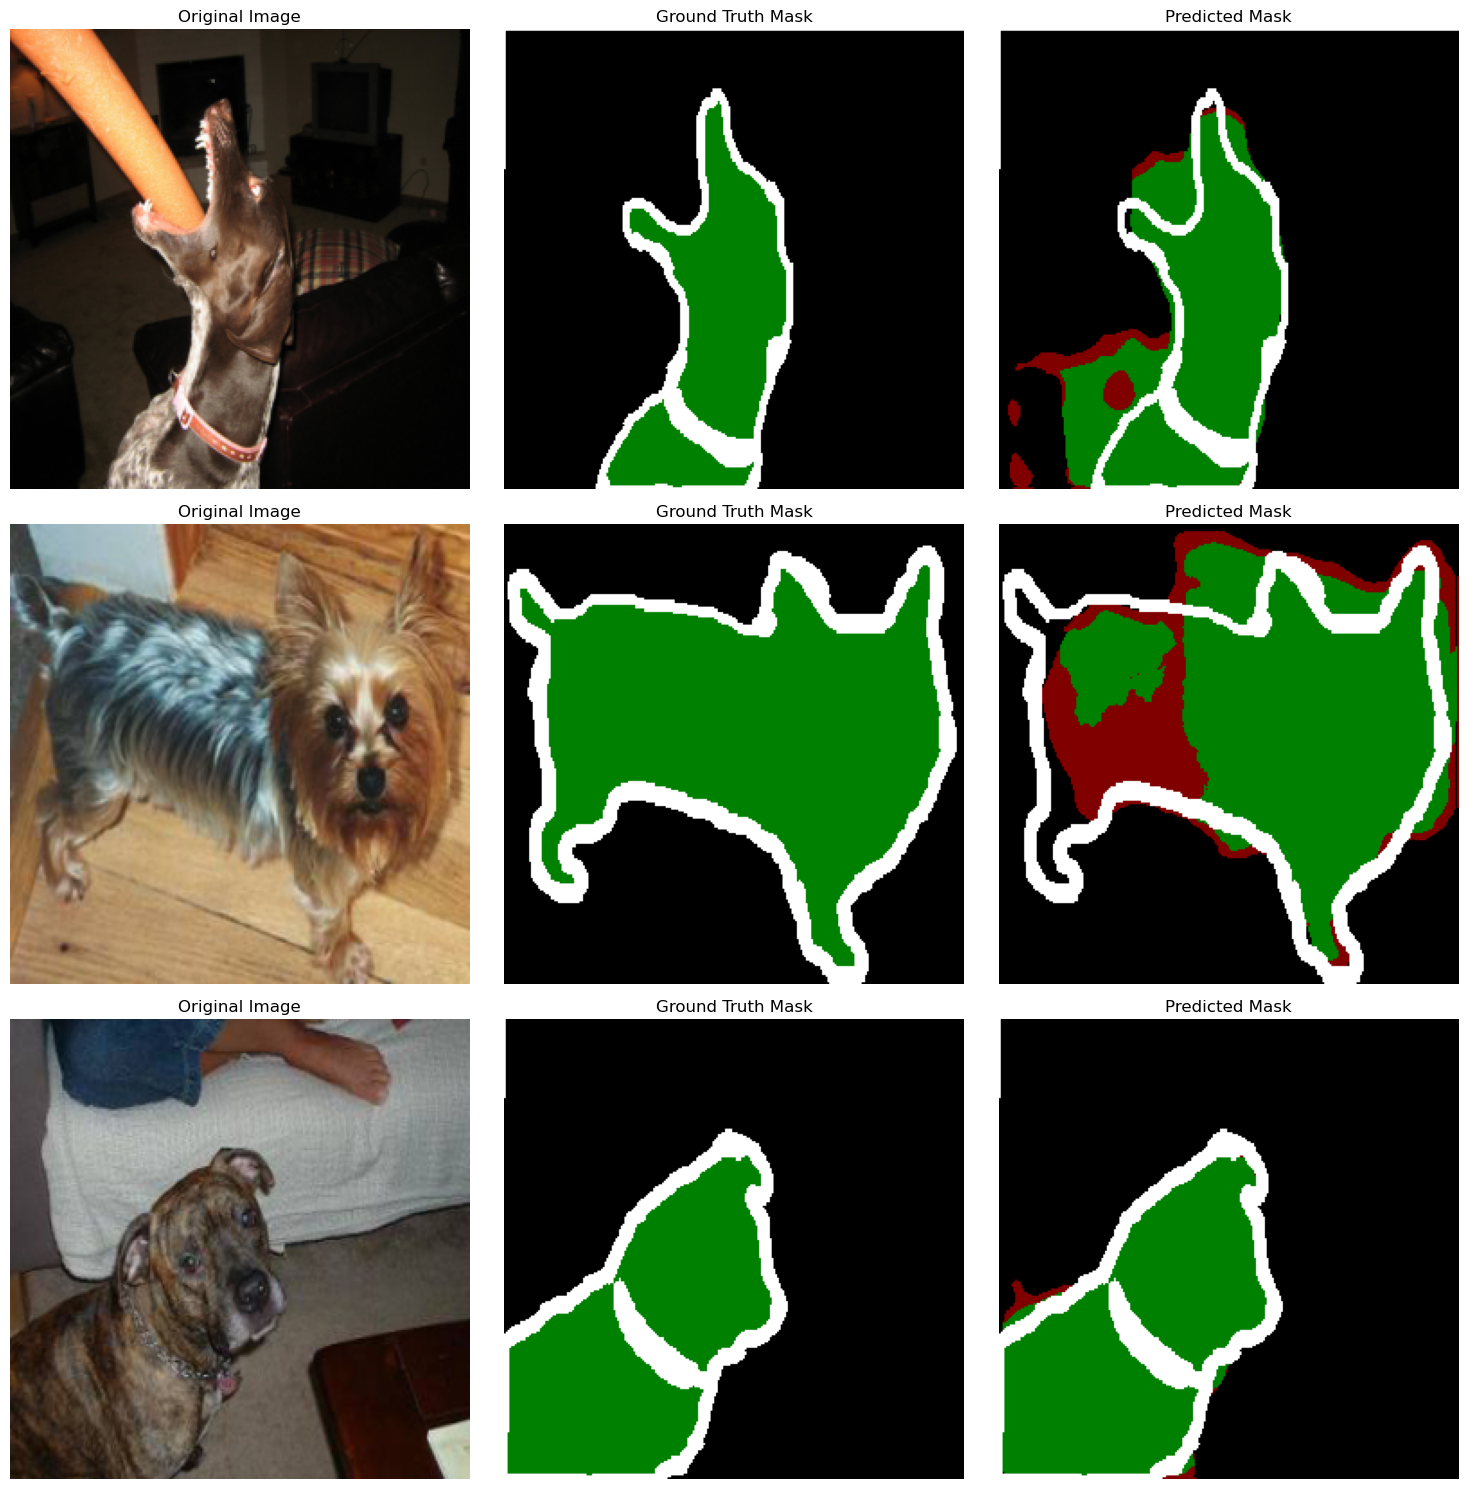

In [12]:
# Visualize results
print("\nVisualizing U-Net results on validation :")
visualize_unet_results(unet, val_loader, device, num_samples=3)

In [11]:
# Evaluate model on test set
# print("\nEvaluating U-Net on test set:")
# test_results = evaluate_unet(unet, test_loader, device)

In [12]:
# print("\nVisualizing U-Net results on test:")
# visualize_unet_results(unet, test_loader, device, num_samples=3)